
The code implements a Monte Carlo reinforcement learning algorithm, where an RL_Agent learns to play a game by simulating random games against an opponent making random moves (RandomPlayer). The agent updates its Q-function, which represents the expected rewards for actions in various states, based on the outcomes of these simulations. It uses the observed rewards and a learning rate to adjust the Q-values.

Despite experimenting with different learning rates and training iterations, the RL agent does not outperform the random player, as shown in the attached chart. The consistently poor results across various learning rates and iteration counts suggest that the number of iterations may still be insufficient for effective learning by the Monte Carlo RL agent.




In [1]:
import random
from game import Game, Move, Player
from copy import deepcopy
import sys
import numpy as np

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        #game.print()
        from_pos = (random.randint(0, 4), random.randint(0, 4))
        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move

In [3]:
from random import choice
from collections import defaultdict

class RL_Agent(Player):
    def __init__(self) -> None:
        super().__init__()
        self.Q_function = defaultdict(float)

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        possible_moves = self.possible_moves(game, 0)  # Get all possible moves for the player
        max_reward = -float('inf')  # Initialize max_reward with the lowest possible value
        best_move = None  # Initialize best_move with None
        board_state = tuple(map(tuple, game._board))  # Convert the game board to a hashable tuple for the Q-function

        for move in possible_moves:
            reward = self.Q_function[(board_state, move)]
            if reward > max_reward:
                max_reward = reward
                best_move = move
        
        from_position, move = best_move
        return from_position, move
    
    def random_game_simulation(self):
        state = Game()  # Initialize a new game
        game_trajectory = []  # Track the sequence of moves and states

        while True:
            # Player's turn (agent)
            move = choice(self.possible_moves(state, 0))
            game_trajectory.append((deepcopy(state), move))  # Record the state and the chosen move
            state.move(*move, 0)  # Execute the move

            # Check if the game has ended after the player's move
            if state.check_winner() != -1:
                break

            # Opponent's turn
            opponent_move = choice(self.possible_moves(state, 1))
            state.move(*opponent_move, 1)  # Execute the opponent's move

            # Check if the game has ended after the opponent's move
            if state.check_winner() != -1:
                break
            
        return game_trajectory, state  # Return the trajectory and the final state of the game

    def state_value(self, state):
        # Evaluate the state value based on the game outcome
        return 1 if state.check_winner() == 0 else -1
    
    def train_agent(self, iterations, learning_rate=0.01):
        for _ in range(iterations):
            trajectory, final_state = self.random_game_simulation()  # Simulate a random game
            reward = self.state_value(final_state)  # Get the final reward based on the game outcome
            # Update Q-function based on the trajectory of the game
            for (state, action) in trajectory:
                board_state = tuple(map(tuple, state._board))  # Convert board to a tuple for hashing
                state_action_pair = (board_state, action)
                self.Q_function[state_action_pair] += learning_rate * (reward - self.Q_function[state_action_pair])
    


    def valid_move(self, position, action):
            # True if the move does not attempt to go beyond the board's boundaries; otherwise, False.
        return not ((position[1] == 0 and action == Move.TOP)  # Can't move up from the top edge
                or (position[1] == 4 and action == Move.BOTTOM)  # Can't move down from the bottom edge
                or (position[0] == 0 and action == Move.LEFT)  # Can't move left from the left edge
                or (position[0] == 4 and action == Move.RIGHT))  # Can't move right from the right edge

    def possible_moves(self, game, player):
        # Generate potential positions on the edges of the board that are valid for the player.
        potential_positions = [(i, j) for i in range(5) for j in range(5)
                            if (i == 0 or i == 4 or j == 0 or j == 4)  # Position is on the edge
                            and (game._board[j, i] == -1 or game._board[j, i] == player)]  # Position is unoccupied or occupied by the player

        # Generate all possible moves from these positions, considering all four directions.
        potential_moves = [(position, action) for position in potential_positions for action in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]]

        # Filter out moves that are not valid (i.e., would move off the board).
        potential_moves = [(position, action) for position, action in potential_moves if self.valid_move(position, action)]

    # Return the filtered list of valid moves.
        return potential_moves
    
    def display_best_actions(self, top_n):
            # Display the top N actions based on their Q-values
            top_actions = sorted(self.Q_function.items(), key=lambda x: x[1], reverse=True)[:top_n]
            for (state_action, value) in top_actions:
                print(f'State-Action: {state_action}, Value: {value}\n')

In [4]:
def simulate_games(num_games=1000):
    wins = {0: 0, 1: 0, 'draws': 0}
    
    player1 = RL_Agent()
    player2 = RandomPlayer()

    training_iterations = 200000
    player1.train_agent(training_iterations)


    for _ in range(num_games):
        game = Game()  # Initialize a new game instance
        winner = game.play(player1, player2)
        if winner != -1:
            wins[winner] += 1
        else:
            wins['draws'] += 1  

    return wins

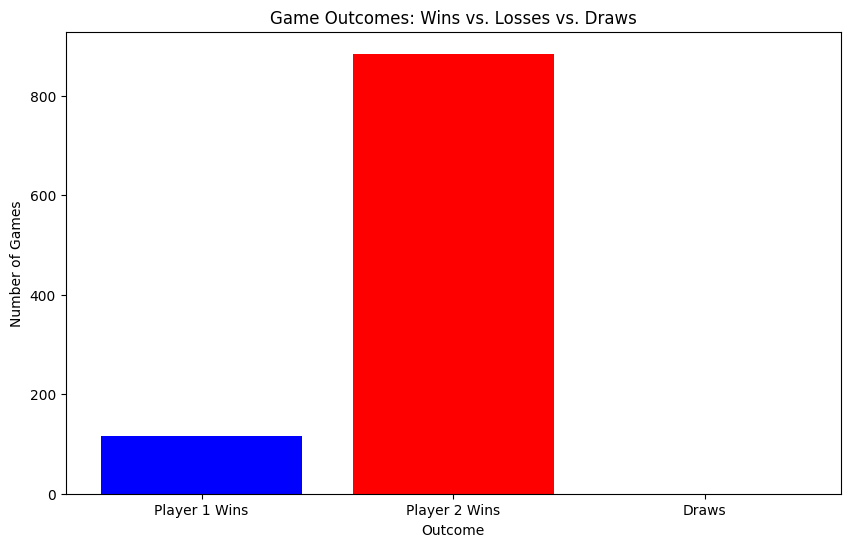

In [5]:
import matplotlib.pyplot as plt

wins = simulate_games(num_games=1000)


# Data for plotting
labels = ['Player 1 Wins', 'Player 2 Wins', 'Draws']
values = [wins[0], wins[1], wins['draws']]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Number of Games')
plt.title('Game Outcomes: Wins vs. Losses vs. Draws')
plt.xticks(labels)
plt.show()

In [6]:
from random import choice
from collections import defaultdict

class RL_Agent(Player):
    def __init__(self) -> None:
        super().__init__()
        self.Q_function = defaultdict(float)

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        possible_moves = self.possible_moves(game, 0)  # Get all possible moves for the player
        max_reward = -float('inf')  # Initialize max_reward with the lowest possible value
        best_move = None  # Initialize best_move with None
        board_state = tuple(map(tuple, game._board))  # Convert the game board to a hashable tuple for the Q-function

        for move in possible_moves:
            reward = self.Q_function[(board_state, move)]
            if reward > max_reward:
                max_reward = reward
                best_move = move
        
        from_position, move = best_move
        return from_position, move
    
    def random_game_simulation(self):
        state = Game()  # Initialize a new game
        game_trajectory = []  # Track the sequence of moves and states

        while True:
            # Player's turn (agent)
            move = choice(self.possible_moves(state, 0))
            game_trajectory.append((deepcopy(state), move))  # Record the state and the chosen move
            state.move(*move, 0)  # Execute the move

            # Check if the game has ended after the player's move
            if state.check_winner() != -1:
                break

            # Opponent's turn
            opponent_move = choice(self.possible_moves(state, 1))
            state.move(*opponent_move, 1)  # Execute the opponent's move

            # Check if the game has ended after the opponent's move
            if state.check_winner() != -1:
                break
            
        return game_trajectory, state  # Return the trajectory and the final state of the game

    def state_value(self, state):
        # Evaluate the state value based on the game outcome
        return 1 if state.check_winner() == 0 else -1
    
    def train_agent(self, iterations, learning_rate=0.25):
        for _ in range(iterations):
            trajectory, final_state = self.random_game_simulation()  # Simulate a random game
            reward = self.state_value(final_state)  # Get the final reward based on the game outcome
            # Update Q-function based on the trajectory of the game
            for (state, action) in trajectory:
                board_state = tuple(map(tuple, state._board))  # Convert board to a tuple for hashing
                state_action_pair = (board_state, action)
                self.Q_function[state_action_pair] += learning_rate * (reward - self.Q_function[state_action_pair])
    

    def valid_move(self, position, action):
            # True if the move does not attempt to go beyond the board's boundaries; otherwise, False.
        return not ((position[1] == 0 and action == Move.TOP)  # Can't move up from the top edge
                or (position[1] == 4 and action == Move.BOTTOM)  # Can't move down from the bottom edge
                or (position[0] == 0 and action == Move.LEFT)  # Can't move left from the left edge
                or (position[0] == 4 and action == Move.RIGHT))  # Can't move right from the right edge

    def possible_moves(self, game, player):
        # Generate potential positions on the edges of the board that are valid for the player.
        potential_positions = [(i, j) for i in range(5) for j in range(5)
                            if (i == 0 or i == 4 or j == 0 or j == 4)  # Position is on the edge
                            and (game._board[j, i] == -1 or game._board[j, i] == player)]  # Position is unoccupied or occupied by the player

        # Generate all possible moves from these positions, considering all four directions.
        potential_moves = [(position, action) for position in potential_positions for action in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]]

        # Filter out moves that are not valid (i.e., would move off the board).
        potential_moves = [(position, action) for position, action in potential_moves if self.valid_move(position, action)]

    # Return the filtered list of valid moves.
        return potential_moves
    
    def display_best_actions(self, top_n):
            # Display the top N actions based on their Q-values
            top_actions = sorted(self.Q_function.items(), key=lambda x: x[1], reverse=True)[:top_n]
            for (state_action, value) in top_actions:
                print(f'State-Action: {state_action}, Value: {value}\n')

In [7]:
def simulate_games(num_games=1000):
    wins = {0: 0, 1: 0, 'draws': 0}
    
    player1 = RL_Agent()
    player2 = RandomPlayer()

    training_iterations = 100000
    player1.train_agent(training_iterations)


    for _ in range(num_games):
        game = Game()  # Initialize a new game instance
        winner = game.play(player1, player2)
        if winner != -1:
            wins[winner] += 1
        else:
            wins['draws'] += 1  

    return wins

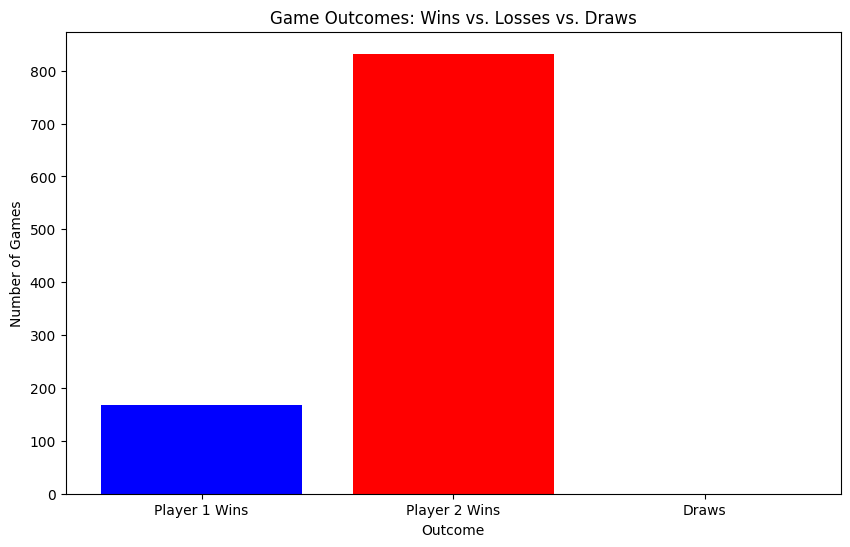

In [8]:
import matplotlib.pyplot as plt

wins = simulate_games(num_games=1000)


# Data for plotting
labels = ['Player 1 Wins', 'Player 2 Wins', 'Draws']
values = [wins[0], wins[1], wins['draws']]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Number of Games')
plt.title('Game Outcomes: Wins vs. Losses vs. Draws')
plt.xticks(labels)
plt.show()

In [3]:
from random import choice
from collections import defaultdict

class RL_Agent(Player):
    def __init__(self) -> None:
        super().__init__()
        self.Q_function = defaultdict(float)

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        possible_moves = self.possible_moves(game, 0)  # Get all possible moves for the player
        max_reward = -float('inf')  # Initialize max_reward with the lowest possible value
        best_move = None  # Initialize best_move with None
        board_state = tuple(map(tuple, game._board))  # Convert the game board to a hashable tuple for the Q-function

        for move in possible_moves:
            reward = self.Q_function[(board_state, move)]
            if reward > max_reward:
                max_reward = reward
                best_move = move
        
        from_position, move = best_move
        return from_position, move
    
    def random_game_simulation(self):
        state = Game()  # Initialize a new game
        game_trajectory = []  # Track the sequence of moves and states

        while True:
            # Player's turn (agent)
            move = choice(self.possible_moves(state, 0))
            game_trajectory.append((deepcopy(state), move))  # Record the state and the chosen move
            state.move(*move, 0)  # Execute the move

            # Check if the game has ended after the player's move
            if state.check_winner() != -1:
                break

            # Opponent's turn
            opponent_move = choice(self.possible_moves(state, 1))
            state.move(*opponent_move, 1)  # Execute the opponent's move

            # Check if the game has ended after the opponent's move
            if state.check_winner() != -1:
                break
            
        return game_trajectory, state  # Return the trajectory and the final state of the game

    def state_value(self, state):
        # Evaluate the state value based on the game outcome
        return 1 if state.check_winner() == 0 else -1
    
    def train_agent(self, iterations, learning_rate):
        for _ in range(iterations):
            trajectory, final_state = self.random_game_simulation()  # Simulate a random game
            reward = self.state_value(final_state)  # Get the final reward based on the game outcome
            # Update Q-function based on the trajectory of the game
            for (state, action) in trajectory:
                board_state = tuple(map(tuple, state._board))  # Convert board to a tuple for hashing
                state_action_pair = (board_state, action)
                self.Q_function[state_action_pair] += learning_rate * (reward - self.Q_function[state_action_pair])
    

    def valid_move(self, position, action):
            # True if the move does not attempt to go beyond the board's boundaries; otherwise, False.
        return not ((position[1] == 0 and action == Move.TOP)  # Can't move up from the top edge
                or (position[1] == 4 and action == Move.BOTTOM)  # Can't move down from the bottom edge
                or (position[0] == 0 and action == Move.LEFT)  # Can't move left from the left edge
                or (position[0] == 4 and action == Move.RIGHT))  # Can't move right from the right edge

    def possible_moves(self, game, player):
        # Generate potential positions on the edges of the board that are valid for the player.
        potential_positions = [(i, j) for i in range(5) for j in range(5)
                            if (i == 0 or i == 4 or j == 0 or j == 4)  # Position is on the edge
                            and (game._board[j, i] == -1 or game._board[j, i] == player)]  # Position is unoccupied or occupied by the player

        # Generate all possible moves from these positions, considering all four directions.
        potential_moves = [(position, action) for position in potential_positions for action in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]]

        # Filter out moves that are not valid (i.e., would move off the board).
        potential_moves = [(position, action) for position, action in potential_moves if self.valid_move(position, action)]

    # Return the filtered list of valid moves.
        return potential_moves

    def display_best_actions(self, top_n):
            # Display the top N actions based on their Q-values
            top_actions = sorted(self.Q_function.items(), key=lambda x: x[1], reverse=True)[:top_n]
            for (state_action, value) in top_actions:
                print(f'State-Action: {state_action}, Value: {value}\n')

In [4]:
def run_simulations_with_different_settings():
    learning_rates = [0.2, 0.25, 0.3, 0.5]
    iteration_counts = [50000, 100000, 200000]
    
    simulation_results = {}
    
    for learning_rate in learning_rates:
        for iterations in iteration_counts:
            wins = {0: 0, 1: 0, 'draws': 0}
            # Initialize the RL agent and a random player for each set of parameters
            rl_agent = RL_Agent()
            random_player = RandomPlayer()
            
            # Train the RL agent
            rl_agent.train_agent(iterations, learning_rate)
            
            # Simulate games and store the results
            for _ in range(1000):
                game = Game()  # Initialize a new game instance
                winner = game.play(rl_agent, random_player)
                if winner != -1:
                    wins[winner] += 1
                else:
                    wins['draws'] += 1
                    
            simulation_key = f"LR: {learning_rate}, Iterations: {iterations}"
            simulation_results[simulation_key] = wins
            
            # Optionally, reset or reinitialize the RL agent here if needed
            
    return simulation_results

In [5]:
import matplotlib.pyplot as plt

def plot_simulation_results(simulation_results):
    # Prepare the data
    labels = simulation_results.keys()
    player1_wins = [result[0] for result in simulation_results.values()]
    player2_wins = [result[1] for result in simulation_results.values()]
    draws = [result['draws'] for result in simulation_results.values()]
    
    # Plotting
    x = range(len(labels))
    plt.figure(figsize=(12, 8))
    
    plt.bar(x, player1_wins, width=0.2, label='Player 1 Wins', color='blue')
    plt.bar(x, player2_wins, width=0.2, bottom=player1_wins, label='Player 2 Wins', color='red')
    plt.bar(x, draws, width=0.2, bottom=[i+j for i,j in zip(player1_wins, player2_wins)], label='Draws', color='green')
    
    plt.xlabel('Settings')
    plt.ylabel('Number of Games')
    plt.title('RL Agent Performance Across Different Settings')
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.legend(loc='upper left')
    plt.show()

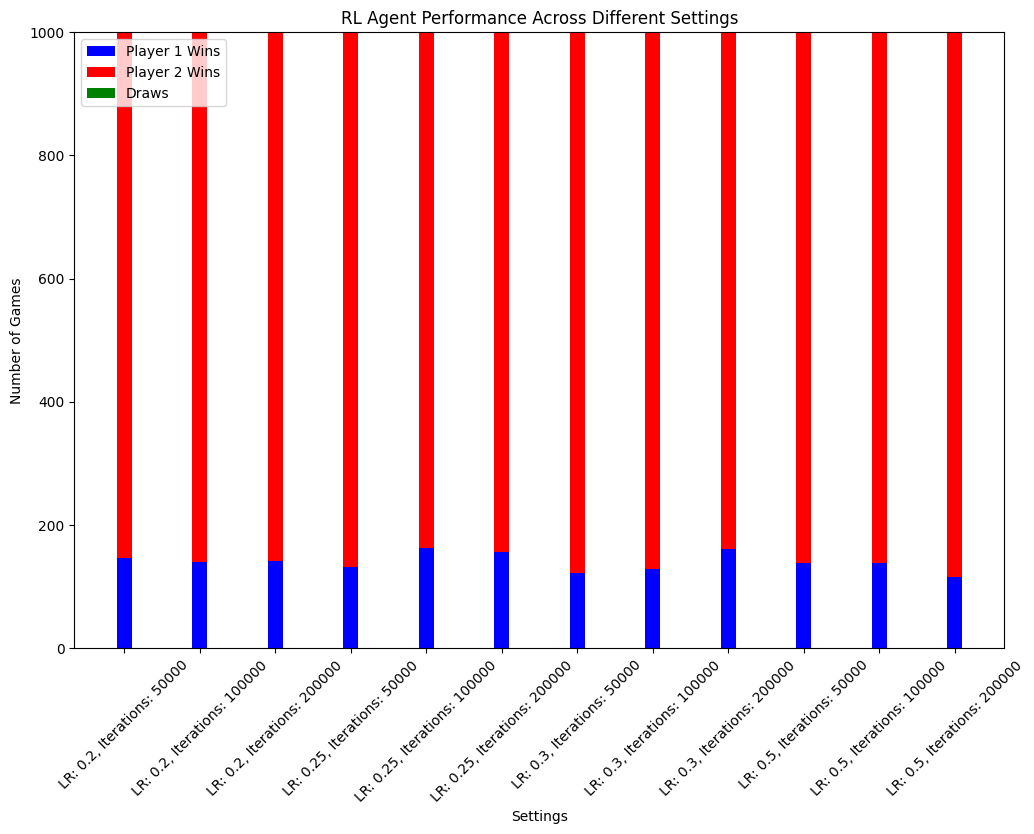

In [6]:
simulation_results = run_simulations_with_different_settings()
plot_simulation_results(simulation_results)